<a href="https://colab.research.google.com/github/ali3brt/20-Newsgroups-Dataset/blob/main/02_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

**Autoencoders** are a particular type of neural network, just like classifiers. Autoencoders are similar to classifiers in the sense that they compress data. However, where classifiers condense all the data of an image into a single label, autoencoders compress the data into a **latent vector**, often denoted $z$ in literature, with the goal of preserving the opportunity to recreate the exact same image in the future. Because autoencoders learn representations instead of labels, autoencoders belong to representation learning, a subfield of machine learning, but not necessarily deep learning.





 Autoencoders  find patterns in data.

## Architecture
Autoencoders consist of two networks:

* Encoder
* Decoder

The goal of the **encoder** is to compress an image, video, or any piece of data that can be represented as a tensor, into a _latent vector_. The **decoder** does, as you might have guessed, the exact opposite.

To maximize performance, minimize the loss that is, encoders and decoders are typically symmetrical together. Naturally, the input size is equal to the output size of an autoencoder.

Autoencoders always have less input neurons in the middle layer than in the input and output layer. This is called the **bottleneck**. If it weren't for this bottleneck, the autoencoders could just copy this data over from the input to the output layer without compressing it.


## Training

Encoders and decoders _can_ be trained separately, but usually they are trained in one go. In order to do so, one stacks the coders together in one **stacked autoencoder**.

If one desires to train autoencoders separately, one starts by using the first hidden layer, discadring every other layer, except for the input and output layers of course. He uses the original training data at this point. Next, he uses the latent vector $z$ learnt by this mini-autoencoder and trains another autoencoder in the same way, treating the latent vectors as original data. Once the desired depth is reached, one can stack all output layers, which provided the latent vectors, together in a sinle encoder. This approach is not used in practise a lot, but literature might refer to it as greedy layerwise training so it's good to know what it means.

## Appliciations

While the phase "finding patterns" might not seem very interesting, there are a lot of exciting applications of autoencoders. We will look at three of those today:

1. Dense autoencoder: compressing data.
2. Convolutional autoencoder: a building block of DCGANs, self-supervised learning.
3. Denoising autoencoder: removing noise from poor training data.

While all of these applications use pattern finding, they have different use cases making autoencoders one of the most exciting topics of machine learning.

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
from tensorflow import keras

## Loading the data

We will load MNIST, but without labels because representation learning is **unsupervised**, or **self-supervised** which is the prefered term. (https://twitter.com/ylecun/status/1123235709802905600)

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train / 255
x_test = x_test / 255

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## A simple autoencoder

Let's start by looking at the simplest possible autoencoder.

The `encoder` is a sequential neural network with $28 \times 28$ input neurons, $100$ neurons in the second layer and $30$ in the third. The third layer is called the "bottleneck". Feel free to play around with this variable to see how it affects results.

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu"),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The decoder is the same, but in opposite order. Note that keras needs to know the input shape at this point. The input shape of the decoder is the shape of $z$, also called `zDim` as you will see later on.

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Now stack them for training:

In [ ]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

Note that we use binary cross entropy loss in stead of categorical cross entropy. The reason for that is because we are not classifying latent vectors to belong to a particular class, we do not even have classes!, but rather are trying to predict whether a pixel should be activated or not.

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                   optimizer='adam')

Notice how the $x$ and $y$, both $x$, `x_train` if you like, are equal:

In [ ]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                                  validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.1968 - val_loss: 0.1068
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1048 - val_loss: 0.0966
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0965 - val_loss: 0.0926
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0935 - val_loss: 0.0905
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0914 - val_loss: 0.0893
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0899 - val_loss: 0.0885
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0890 - val_loss: 0.0872
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0879 - val_loss: 0.0867
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0875 - val_loss: 0.0862
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0868 - val_loss: 0.0857


Let's look at how the autoencoder reconstructs images.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


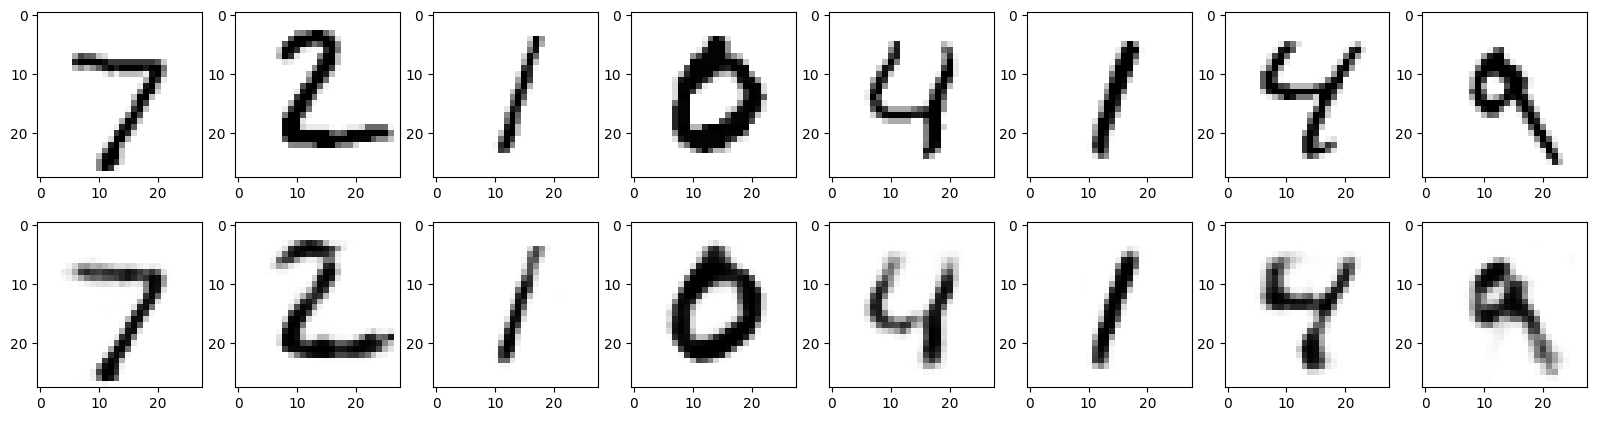

In [ ]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Just from this vector:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


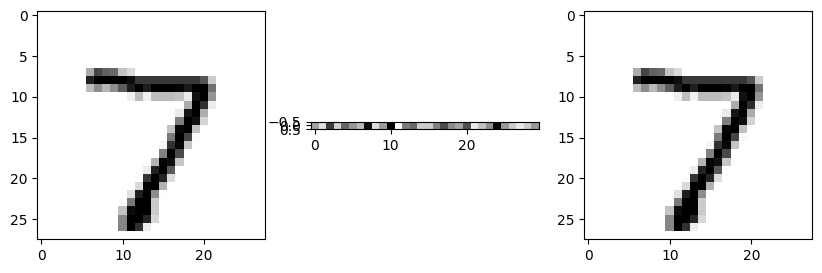

In [ ]:
i = 0 # change this number

figsize(10, 5)

subplot(1, 3, 1)
imshow(x_test[i], cmap="binary")

subplot(1, 3, 2)
latent_vector = encoder.predict(x_test[i].reshape((1, 28, 28)))
imshow(latent_vector, cmap="binary")

subplot(1, 3, 3)
pred = decoder.predict(latent_vector)
imshow(x_test[i], cmap="binary")

In [ ]:
30 / (28 * 28), 1 - 30 / (28 * 28)

(0.03826530612244898, 0.9617346938775511)

That's 96.2% compression! Pretty amazing, huh?

## Convolutional autoencoder

Apart from data compression, autoencoders can also be used for self-supervised image classification.

The first layers of the encoder learn to recognize patterns in the data very well in order to compress the data. If you don't have access to much labelled data, but a lot of unlabelled data, it's possible to train an autoencoder and copy the first layers from the autoencoder to the classifier network. This can be compared to transfer learning, where you only have to train the head afterwards.

It is well known that convolutional layers are perfect for finding patterns in data, so it's good to know they can also be used in autoencoders. To "de-convolve" images in the decoder, transposed convolutional layers are used. For more information on transposed convolutional layers, checkout [this blog post](https://rickwierenga.com/blog/s4tf/s4tf-gan.html) I have written which explains them in more detail. See the last section "Autoencoders and GANs" of this notebook for more information on the beautiful relation between GANs and autoencoders.

Let's look at a convolutional encoder:

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


The weights learnt by this encoder could be copied to the classifier.

In [ ]:
encoder.predict(x_test[0].reshape((1, 28, 28))).shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(1, 3, 3, 64)

Notice how $z \in \mathbb{R}^{1 \times 3 \times 3 \times 64}$. Now we build its counterpart, the decoder, with transposed convolutional layers to recreate a grayscale $28 \times 28$ image.

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=2, padding="valid",
                                 activation="relu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="relu"),
    keras.layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=2, padding="same",
                                 activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv_transpose.py:94: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [ ]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

In [ ]:
history = stacked_autoencoder.fit(x_train, x_train, epochs=10,
                         validation_data=[x_test, x_test])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.1914 - val_loss: 0.0830
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0825 - val_loss: 0.0777
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0775 - val_loss: 0.0751
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0751 - val_loss: 0.0728
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0733 - val_loss: 0.0716
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0722 - val_loss: 0.0706
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0713 - val_loss: 0.0701
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0705 - val_loss: 0.0693
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0700 - val_loss: 0.0689
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0696 - val_loss: 0.0688


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


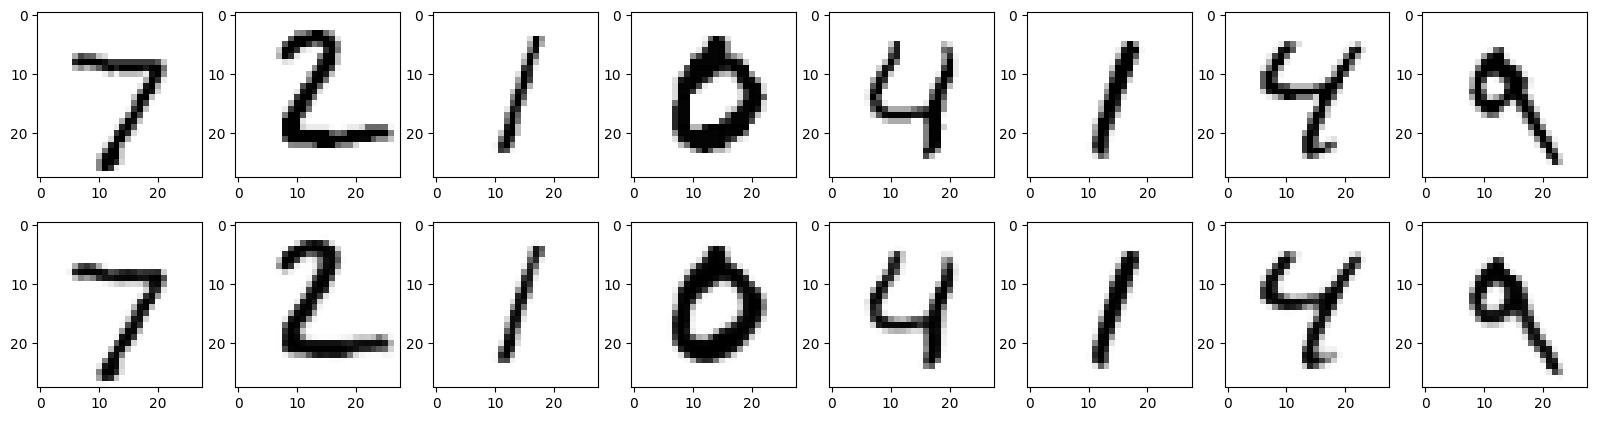

In [ ]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  pred = stacked_autoencoder.predict(x_test[i].reshape((1, 28, 28)))
  imshow(x_test[i], cmap="binary")

  subplot(2, 8, i+8+1)
  imshow(pred.reshape((28, 28)), cmap="binary")

Let's look at the weights the encoder learnt. Note that $\sqrt{64} = 8$.

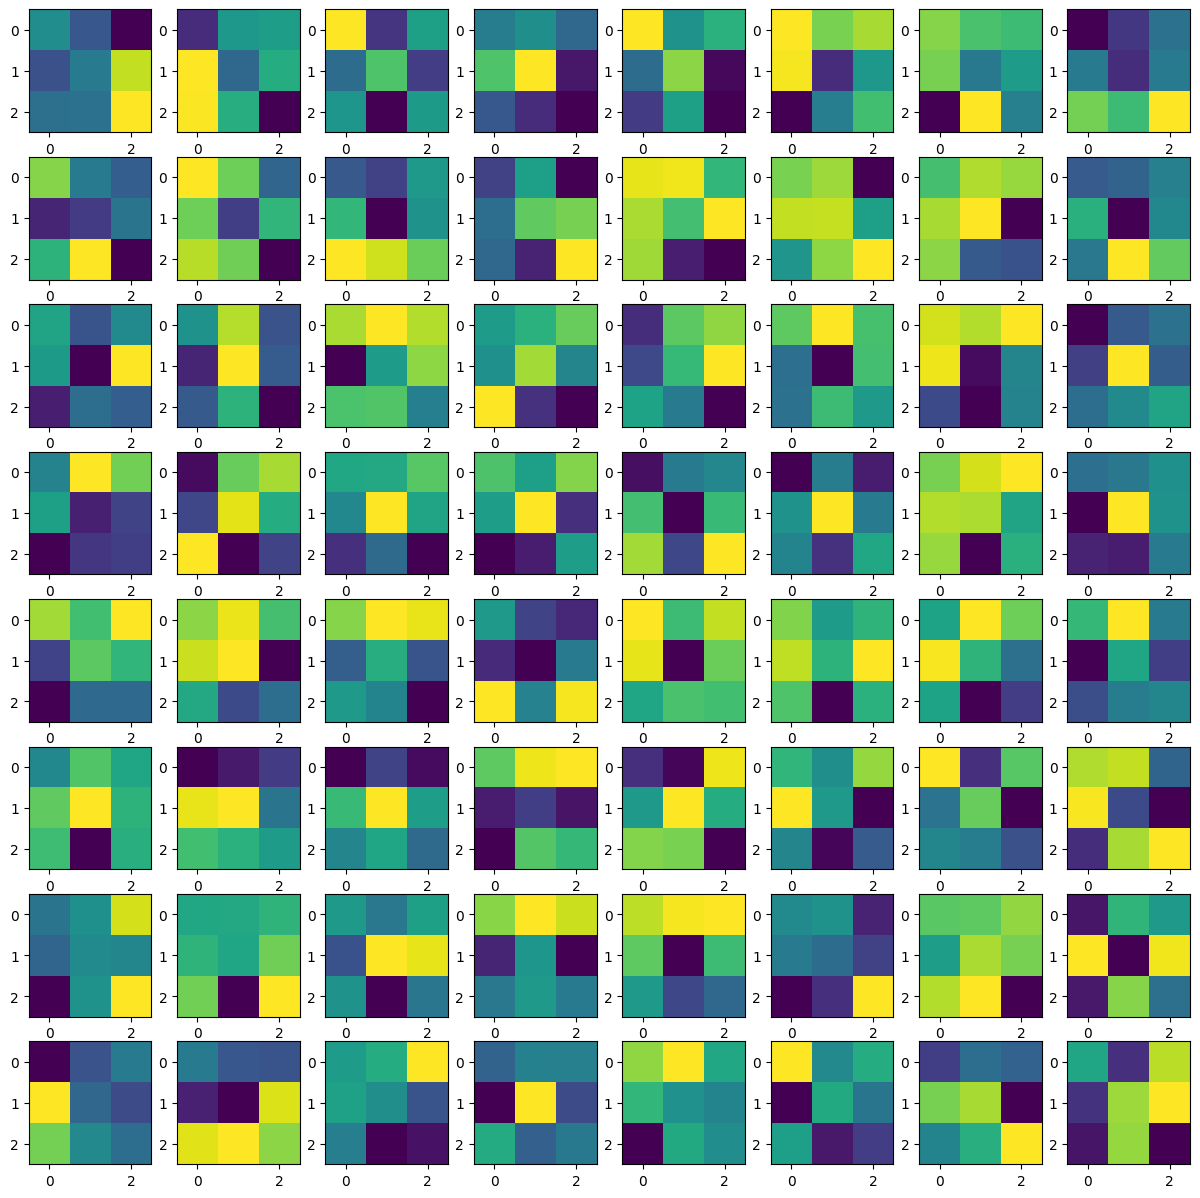

In [ ]:
figsize(15, 15)
for i in range(8 * 8):
  subplot(8, 8, i+1)
  imshow(encoder.layers[-2].weights[0][:, :, 0, i])

Visually not very pleasing, but proven to be effective as shown in the previous figure.

$3 \times 3 \times 64=576$ is still less than $28 \times 28 = 784$, thus creating a bottleneck, but much less compressed than the dense encoder making convolutional encoders less suitable for comporession. But thanks to their convolutional layers, they are great to use in cases where you want your autoencoder to find visual patterns in your data.

## Denoising autoencoder

The last application of autoencoders we look at today are denoising autoencoders. You probably have no difficulty classifying the images below as 7's.

In [ ]:
import numpy as np

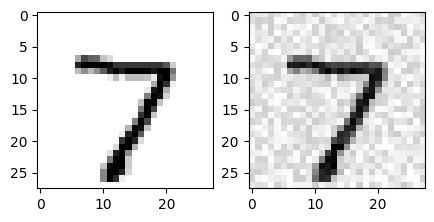

In [ ]:
figsize(5, 10)
subplot(1, 2, 1)
imshow(x_test[0], cmap="binary")

subplot(1, 2, 2)
noise = np.random.random((28, 28)) / 4
imshow(x_test[0] + noise, cmap="binary")

But in machine learning, this noise can be catasrophic. Luckily machine learning also has a solution for this problem: auto encoders!

By applying noise to the images inputted to the encoder and setting the clean image as desired output, $y$, an autoencoder can learn to remove noise from the image.

Let's look at such an encoder:

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(30, activation="relu")
])

In [ ]:
decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="relu", input_shape=[30]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [ ]:
stacked_autoencoder = keras.models.Sequential([encoder, decoder])

In [ ]:
stacked_autoencoder.compile(loss="binary_crossentropy",
                            optimizer='adam')

Now create a dataset filled with noise:

In [ ]:
x_train_noise = x_train + ((np.random.random(x_train.shape)) / 4)
x_test_noise = x_test + ((np.random.random(x_test.shape)) / 4)

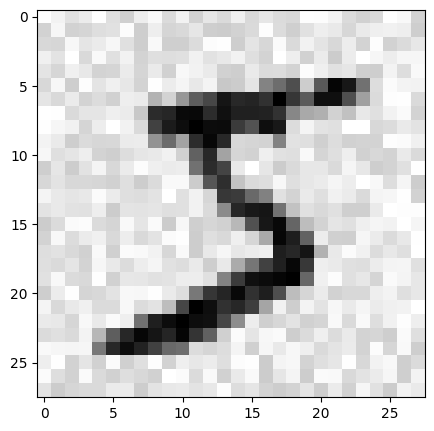

In [ ]:
imshow(x_train_noise[0], cmap="binary")

And finally train the stacked autoencoder with noise input data and clean output data.

In [ ]:
history = stacked_autoencoder.fit(x_train_noise, x_train, epochs=10,
                                  validation_data=[x_test_noise, x_test])

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2145 - val_loss: 0.1295
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1251 - val_loss: 0.1136
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1141 - val_loss: 0.1091
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1093 - val_loss: 0.1063
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1064 - val_loss: 0.1039
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1040 - val_loss: 0.1017
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1025 - val_loss: 0.1009
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.1013 - val_loss: 0.1002
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1003 - val_loss: 0.0988
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0994 - val_loss: 0.0987


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


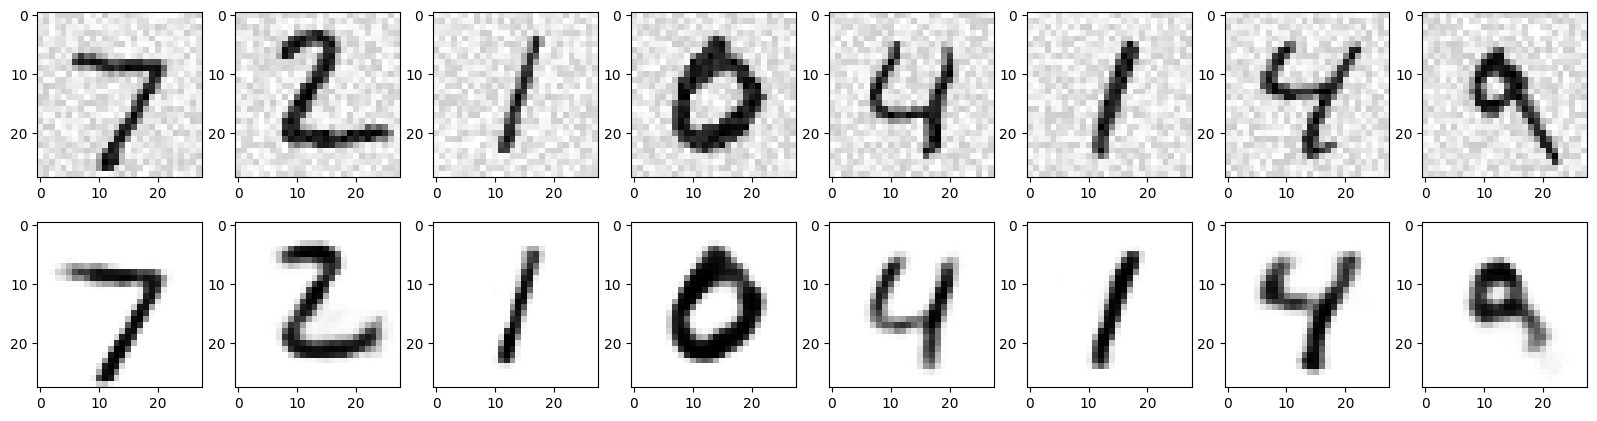

In [ ]:
figsize(20, 5)
for i in range(8):
  subplot(2, 8, i+1)
  imshow(x_test_noise[i], cmap="binary")

  subplot(2, 8, i+8+1)
  pred = stacked_autoencoder.predict(x_test_noise[i].reshape((1, 28, 28)))
  imshow(pred.reshape((28, 28)), cmap="binary")

Calculating reconstruction errors for normal data...


  0%|          | 0/1000 [00:00<?, ?sample/s]

Detecting anomalies...


  0%|          | 0/100 [00:00<?, ?sample/s]

Detected 100 anomalies out of 100 samples


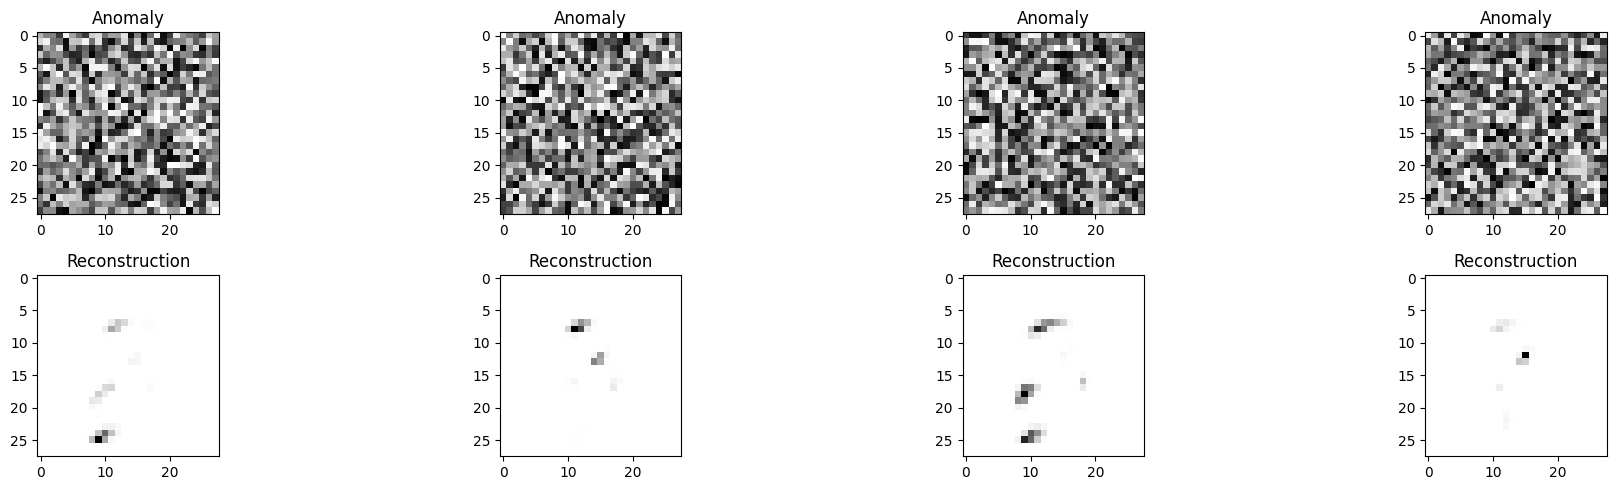

In [ ]:
# Anomaly Detection using the Autoencoder

## Step 1: Calculate reconstruction error for normal data
normal_reconstruction_errors = []

# Use tqdm for a single progress bar
from tqdm.auto import tqdm

# Limit the number of samples
max_samples = 1000  # You can adjust this number as needed

print("Calculating reconstruction errors for normal data...")
for x in tqdm(x_test[:max_samples], total=max_samples, unit='sample'):
    x_reconstructed = stacked_autoencoder.predict(x.reshape((1, 28, 28)), verbose=0)
    reconstruction_error = np.mean(np.square(x - x_reconstructed))
    normal_reconstruction_errors.append(reconstruction_error)

## Step 2: Set a threshold for anomaly detection
threshold = np.mean(normal_reconstruction_errors) + 2 * np.std(normal_reconstruction_errors)

## Step 3: Create some anomalous data
num_anomalous = 100  # You can adjust this number as needed
anomalous_data = np.random.rand(num_anomalous, 28, 28)  # Random noise as anomalies

## Step 4: Detect anomalies
anomalies = []

print("Detecting anomalies...")
for i, x in enumerate(tqdm(anomalous_data, total=num_anomalous, unit='sample')):
    x_reconstructed = stacked_autoencoder.predict(x.reshape((1, 28, 28)), verbose=0)
    reconstruction_error = np.mean(np.square(x - x_reconstructed))
    if reconstruction_error > threshold:
        anomalies.append(i)

print(f"Detected {len(anomalies)} anomalies out of {num_anomalous} samples")

## Step 5: Visualize some anomalies
figsize(20, 5)
for i in range(min(4, len(anomalies))):
    subplot(2, 4, i+1)
    imshow(anomalous_data[anomalies[i]], cmap="binary")
    title("Anomaly")

    subplot(2, 4, i+5)
    pred = stacked_autoencoder.predict(anomalous_data[anomalies[i]].reshape((1, 28, 28)), verbose=0)
    imshow(pred.reshape((28, 28)), cmap="binary")
    title("Reconstruction")

plt.tight_layout()
plt.show()